<a href="https://colab.research.google.com/github/LucasCRK/DL_project/blob/master/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There is no way to easily save variable state so I thik we just have to be careful to save regurlaly the model.


In [ ]:
!pip install dgl
!pip install networkx
!pip install pin

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#Lucas experimenting in how to build graphs
import glob
import json
import numpy as np
import dgl
import networkx as nx
import torch as th
from collections import OrderedDict

In [ ]:
json_files = glob.glob("/content/drive/My Drive/PhD/Homework/DL_project/json/*.json")
with open(json_files[0], 'r') as json_file:
  data = json.load(json_file) 
  graph = json.loads(data[0])
  labels = json.loads(data[1])

DGLGraph(num_nodes=340, num_edges=1416,
         ndata_schemes={'features': Scheme(shape=(36,), dtype=torch.float32), 'label': Scheme(shape=(340,), dtype=torch.float32)}
         edata_schemes={})


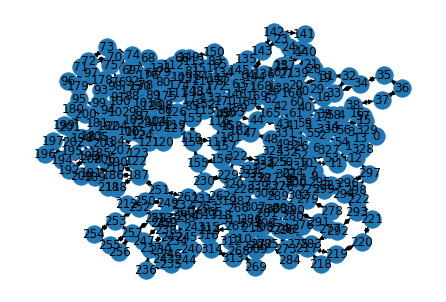

In [ ]:
src = list()
dst = list()

# Get source and destination of edges
for i in  graph["links"]:
  src.append(int(i['source'][1:-3]))
  dst.append(int(i['target'][1:-3]))

# DGL graph has to start at 0 renumber AA
min_idx = np.min(src)
src = np.array(src) - min_idx
dst = np.array(dst) - min_idx

#Make Graph bidirectional
u = np.concatenate([src, dst])
v = np.concatenate([dst, src])

# Map features to node id
node_map = dict()
for i in graph["nodes"]:
  tmp = dict()
  tmp['label'] = labels[i['id']] 
  node_map[i["resi_num"] - min_idx] = {**i, **tmp}

# Create DGL object
G = dgl.DGLGraph((u,v))
pos = nx.kamada_kawai_layout(G.to_networkx())
nx.draw(G.to_networkx(), pos, with_labels=True)

label_tensor = th.tensor([node_map[i]['label'] for i in range(len(G))])


# Add features to each node
G.ndata['features'] = th.randn(len(G), len(node_map[0]['features'][0]))
G.ndata['label'] = th.randn(len(G), len(label_tensor))

print(G)
for i in node_map.keys():
  G.ndata['features'][i] = th.tensor(node_map[i]['features'][0])
  G.ndata['label'][i] = label_tensor


In [ ]:
G.ndata['features'][0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7031,
         0.6399,  2.0000, 10.2875,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

In [ ]:
#Lucas end of experiment

In [ ]:
import matplotlib.pyplot as plt
from pin import ProteinGraph
import pandas as pd
from Bio.PDB import PDBList, PDBIO, PDBParser
import os
from networkx.readwrite import json_graph
import json
import networkx as nx
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv


ModuleNotFoundError: ignored

In [ ]:
# the basic "graph attention layer" and the way to pass the information from node to node
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [ ]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [ ]:
#the real model
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [ ]:
# loading data here 


In [ ]:
##training.

import time
import numpy as np

g, features, labels, mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))